# imports

In [2]:
import os
import torch

# Util function for loading meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
)

import gzip
from pytorch3d.renderer.mesh.textures import TexturesAtlas
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
from utils import image_grid
from typing import Tuple, Dict, List, Optional, Any
from collections import defaultdict
import json
import numpy as np
from scipy.spatial.transform import Rotation

In [3]:

def read_gz_jsonlines(filename):
    data = []
    with open(filename, 'rb') as f:
        for args in map(json.loads, gzip.open(f)):
            data.append(args)
    return data

In [4]:
def load_viewpoints(conn: str) -> Tuple[Dict[str, List], int]:
    """Loads viewpoints into a dictionary of sceneId -> list(viewpoints)
    where each viewpoint has keys {viewpointId, pose, height}.
    """
    viewpoints = []
    with open(os.path.join(conn, "scans.txt")) as f:
        scans = [scan.strip() for scan in f.readlines()]
        for scan in scans:
            with open(os.path.join(conn, f"{scan}_connectivity.json")) as j:
                data = json.load(j)
                for item in data:
                    if item["included"]:
                        viewpoint_data = {
                            "viewpointId": item["image_id"],
                            "pose": item["pose"],
                            "height": item["height"],
                        }
                        viewpoints.append((scan, viewpoint_data))

    scans_to_vps = defaultdict(list)
    for scene_id, viewpoint in viewpoints:
        scans_to_vps[scene_id].append(viewpoint)

    return scans_to_vps, len(viewpoints)

In [14]:
# load viewpoints -> scan : {viewpointid : pose, height}
def load_viewpoints_dict(conn: str) -> Tuple[Dict[str, List], int, Dict[str, Dict]]:
    """Loads viewpoints into a dictionary of sceneId -> viewpoints -> pose, weight
    where each viewpoint has keys viewpointId, and the value has key of pose, height}.
    """
    viewpoints = []
    with open(os.path.join(conn, "scans.txt")) as f:
        scans = [scan.strip() for scan in f.readlines()]
        for scan in scans:
            with open(os.path.join(conn, f"{scan}_connectivity.json")) as j:
                data = json.load(j)
                for item in data:
                    if item["included"]:
                        viewpoint_data = {
                            "viewpointId": item["image_id"],
                            "pose": item["pose"],
                            "height": item["height"],
                        }
                        viewpoints.append((scan, viewpoint_data))

    scans_to_vps = defaultdict(list)
    for scene_id, viewpoint in viewpoints:
        scans_to_vps[scene_id].append(viewpoint)

    scan_to_vp_to_meta = defaultdict(dict)
    for scene_id, viewpoint in viewpoints:
        scan_to_vp_to_meta[scene_id][viewpoint["viewpointId"]] = viewpoint

    return scans_to_vps, len(viewpoints), scan_to_vp_to_meta

In [87]:
import pathlib

MESH_DIR = '/mnt/sw/vln/data/matterport3d/mp3d_mesh/v1/scans/{}/matterport_mesh'

def get_obj_paths(base_dir, scan_ids):
    # Format base_dir with scan_id and create a pathlib.Path object
    obj_files = {}
    for scan_id in scan_ids:
        scan_path = pathlib.Path(base_dir.format(scan_id))
        # Get the first directory inside the scan_path
        obj_file_dir = list(scan_path.iterdir())[0]
        # Find .obj file inside obj_file_dir
        obj_file = [d for d in obj_file_dir.iterdir() if d.suffix == '.obj'][0]
        obj_files[scan_id] = obj_file
    return obj_files

scan_ids = ['17DRP5sb8fy' , 'SN83YJsR3w2']
dir_to_test_objs = get_obj_paths(MESH_DIR, scan_ids)


In [74]:
# load object directly
# verts, faces, aux = load_obj(dir_to_test_obj)
# faces_idx = faces.verts_idx

# # Initialize each vertex to be white in color.
# # verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
# # verts_rgb = torch.tensor(aux.texture_images
# # textures = TexturesVertex(verts_features=verts_rgb.to(device))
# verts_uvs = aux.verts_uvs[None, ...]
# faces_uvs = faces.textures_idx[None, ...]
# tex_maps = aux.texture_images
# texture_image = list(tex_maps.values())[0]
# texture_image = texture_image[None, ...]

# tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)

# view texture

In [26]:
# plt.figure(figsize=(7,7))
# texturesuv_image_matplotlib(scan.textures, subsample=None)
# plt.axis("off");

# load viewpoints

# Load the dataset

In [5]:
rxr_data_dir = '/mnt/sw/vln/data/RxR/rxr_train_guide.jsonl.gz'
train_data = read_gz_jsonlines(rxr_data_dir)

In [6]:
train_data[0]

{'path_id': 0,
 'split': 'train',
 'scan': 'SN83YJsR3w2',
 'heading': 2.6315649473774565,
 'path': ['4471fcf26b3847ed88ce41eca5ecb13d',
  'b2b0b597ef2f4a1c86cbbe335dc2dcc1',
  '16708c282c26467e8e36cc00812c289c'],
 'instruction_id': 0,
 'annotator_id': 0,
 'language': 'en-US',
 'instruction': "You will start by standing in front of a glass door and on your right is a doorway. Turn around and you will see a doorway to the washroom. Walk towards the doorway and inside the washroom. Once you're there, stand in between the sink and the bathtub and once you're there, you're done.",
 'timed_instruction': [{'end_time': 1.5, 'word': 'You', 'start_time': 1.0},
  {'end_time': 1.6, 'word': 'will', 'start_time': 1.5},
  {'start_time': 1.6, 'end_time': 2.2, 'word': 'start'},
  {'start_time': 2.2, 'word': 'by', 'end_time': 2.5},
  {'word': 'standing', 'start_time': 2.5, 'end_time': 3.3},
  {'start_time': 3.3, 'end_time': 3.6, 'word': 'in'},
  {'word': 'front', 'start_time': 3.6, 'end_time': 3.8},
  {

# try render
- [x] Set up the heading change and elevation change
- [x] load the pose matrix from connectivity file
- [x] load mesh 
- [x] set up the correct HFOV, VFOV, and image size, aspect ratio
- [x]  render the image
- [x] compare with the ground truth image, adjust the understanding of camera pose.
- [ ] test speed ?

## Utils

In [17]:
%reload_ext autoreload 
%autoreload 2

In [18]:
# rotate heading to the right by certain degrees.


def normalize(v):
    return v / np.linalg.norm(v)

def rotate_vector(vec, axis, angle_radians):
    rotation = Rotation.from_rotvec(axis * angle_radians, degrees=False)
    return rotation.apply(vec)

# Camera parameters
def rotate_heading(eye, at, up, angle_radians):
    eye = np.array(eye)
    at = np.array(at)
    up = np.array(up)

    look = at - eye
    look_normalized = normalize(look)

    # add negative sign such that turn right is positive
    look_rotated = rotate_vector(look_normalized, up, -angle_radians)

    # Compute the new target position
    at_rotated = eye + look_rotated * np.linalg.norm(look)
    return eye, at_rotated, up

In [19]:
# setting up the correct meta parameters
VFOV = 60
WIDTH = 640
HEIGHT = 480
FOV = VFOV*WIDTH/HEIGHT
HEADINGS = [
    np.deg2rad(30.0 * h)  for h in range(12)
]
ELEVATIONS = [np.deg2rad(e) for e in [-30.0, 0, 30]]

aspect_ratio = 1 # pixel aspect
image_aspect_ratio = 4/3 # image aspect
image_size = (WIDTH, HEIGHT)

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [22]:
_, _, scan_to_vps_to_data = load_viewpoints_dict('/mnt/sw/vln/data/matterport3d/connectivity')
scan = 'SN83YJsR3w2'
viewpointid = '4471fcf26b3847ed88ce41eca5ecb13d'
def load_scan_mesh(scan_id: str, mesh_dir: str, viewpointid: Optional[str] = None) -> Dict[str, Any]:
    # load pose for a random viewpoint (demonstration)
    scan_viewpoints = scan_to_vps_to_data[scan_id]
    if viewpointid is None:
        # randomly sample a viewpoint
        viewpointid = np.random.choice(len(scan_viewpoints.keys()))

    # viewpointid = scan_viewpoints[0]['viewpointId']
    viewpoint_data = scan_viewpoints[viewpointid]
    pose = viewpoint_data['pose']
    height = viewpoint_data['height']
    location = [pose[3], pose[7], pose[11]]
    dir_to_test_obj = get_obj_path(mesh_dir, scan)
    verts, faces, aux = load_obj(dir_to_test_obj, load_textures=True, create_texture_atlas=True)
    atlas = aux.texture_atlas
    if atlas.ndim == 4:
        atlas = atlas.unsqueeze(0)
    textures = TexturesAtlas(atlas=atlas)
    mesh = Meshes(verts=[verts], faces=[faces.verts_idx], textures=textures)
    mesh = mesh.to(device)
    return {
        "mesh": mesh,
        "location": location,
        "viewpointId": viewpointid,
        "pose": pose,
        "atlas": atlas,
    }
# dir_to_test_mtl = '/mnt/sw/vln/data/matterport3d/mp3d_mesh/v1/scans/{}/matterport_mesh/7e39d733f3134410949894d49d072a39/7e39d733f3134410949894d49d072a39.mtl'
# dir_to_test_mtl = dir_to_test_mtl.format(scan)
# load mesh create_texture_atlas = true to collect all textures into one atlas
scan_data = load_scan_mesh(scan, MESH_DIR, viewpointid)

# modify the above function, such that the scan is loaded once, and viewpoint can be changed without reloading!
# 

/mnt/sw/vln/data/matterport3d/mp3d_mesh/v1/scans/SN83YJsR3w2/matterport_mesh/7e39d733f3134410949894d49d072a39/7e39d733f3134410949894d49d072a39.obj


# Visulize texture atlas

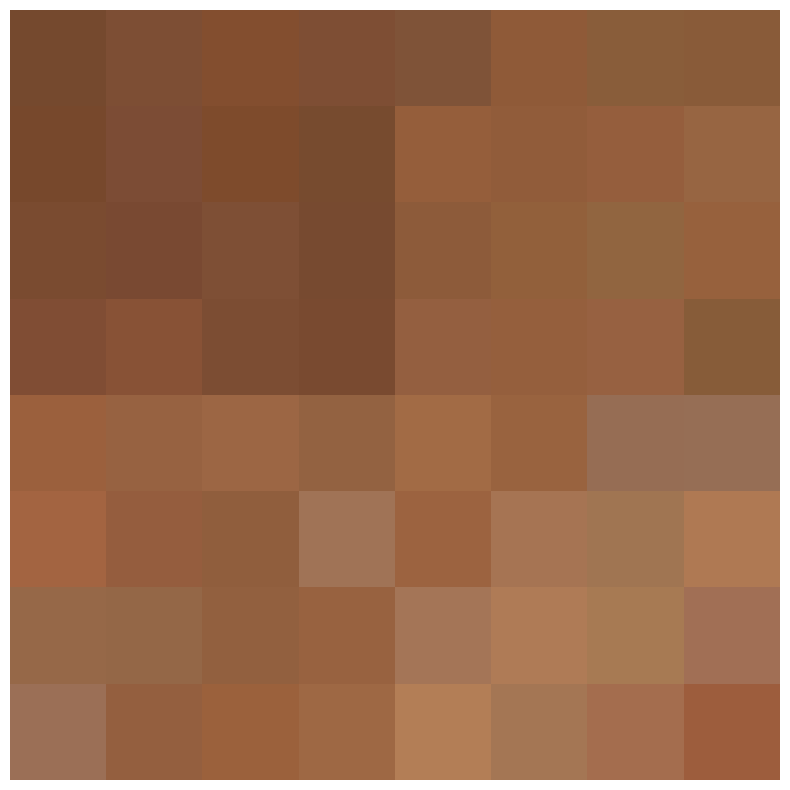

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_texture_atlas(atlas):
    # Convert the atlas to a NumPy array and remove the batch dimension
    atlas_np = atlas.cpu().numpy().squeeze(0)

    # Calculate the number of rows and columns for the grid
    num_faces, height, width, num_channels = atlas_np.shape
    num_rows = int(np.ceil(np.sqrt(num_faces)))
    num_cols = int(np.ceil(np.sqrt(num_faces)))

    # Create an empty grid for the texture atlas image
    atlas_image = np.zeros((num_rows * height, num_cols * width, num_channels), dtype=np.float32)

    # Fill the grid with the face textures from the atlas
    for face_idx, face_texture in enumerate(atlas_np):
        row = face_idx // num_cols
        col = face_idx % num_cols
        atlas_image[row * height:(row + 1) * height, col * width:(col + 1) * width] = face_texture

    # Visualize the texture atlas image
    plt.figure(figsize=(10, 10))
    plt.imshow(atlas_image)
    plt.axis('off')
    plt.show()

# Visualize the texture atlas
atlas = scan_data['atlas']
visualize_texture_atlas(atlas[:, 10000:10004, ...])


In [24]:
import numpy as np
from scipy.spatial.transform import Rotation

def rotate_heading_elevation(eye, at, up, heading, elevation):
    eye = np.array(eye)
    at = np.array(at)
    up = np.array(up)

    # Calculate the view direction and right vector
    view_direction = at - eye
    right = np.cross(view_direction, up)
    # right = (1, 0, 0)

    # Normalize view direction, up, and right vectors
    view_direction = view_direction / np.linalg.norm(view_direction)
    up = up / np.linalg.norm(up)
    right = right / np.linalg.norm(right)

    # Create rotations for heading and elevation
    heading_rotation = Rotation.from_rotvec(-heading * up)
    elevation_rotation = Rotation.from_rotvec(elevation * right)
    combined_rotation = heading_rotation * elevation_rotation

    # Rotate the view direction and up vector
    rotated_view_direction = combined_rotation.apply(view_direction)
    rotated_up_vector = combined_rotation.apply(up)

    # Calculate new at-point
    rotated_at = eye + rotated_view_direction

    return eye.tolist(), rotated_at.tolist(), rotated_up_vector.tolist()

    

In [79]:
# testing
def load_scan_mesh(scan_id: str, mesh_dir: str, viewpointid: Optional[str] = None) -> Dict[str, Any]:
    # load pose for a random viewpoint (demonstration)
    scan_viewpoints = scan_to_vps_to_data[scan_id]
    if viewpointid is None:
        # randomly sample a viewpoint
        viewpointid = np.random.choice(len(scan_viewpoints.keys()))

    # viewpointid = scan_viewpoints[0]['viewpointId']
    viewpoint_data = scan_viewpoints[viewpointid]
    pose = viewpoint_data['pose']
    height = viewpoint_data['height']
    location = [pose[3], pose[7], pose[11]]
    dir_to_test_obj = get_obj_paths(mesh_dir, scan)
    verts, faces, aux = load_obj(dir_to_test_obj, load_textures=True, create_texture_atlas=True, texture_wrap="repeat", texture_atlas_size=30)
    atlas = aux.texture_atlas
    if atlas.ndim == 4:
        atlas = atlas.unsqueeze(0)
    textures = TexturesAtlas(atlas=atlas)
    mesh = Meshes(verts=[verts], faces=[faces.verts_idx], textures=textures)
    mesh = mesh.to(device)
    return {
        "mesh": mesh,
        "location": location,
        "viewpointId": viewpointid,
        "pose": pose,
        "atlas": atlas,
    }
# dir_to_test_mtl = '/mnt/sw/vln/data/matterport3d/mp3d_mesh/v1/scans/{}/matterport_mesh/7e39d733f3134410949894d49d072a39/7e39d733f3134410949894d49d072a39.mtl'
# dir_to_test_mtl = dir_to_test_mtl.format(scan)
# load mesh create_texture_atlas = true to collect all textures into one atlas
scan_data = load_scan_mesh(scan, MESH_DIR, viewpointid)
# initialize the start camera position and location for an episode


/mnt/sw/vln/data/matterport3d/mp3d_mesh/v1/scans/SN83YJsR3w2/matterport_mesh/7e39d733f3134410949894d49d072a39/7e39d733f3134410949894d49d072a39.obj


In [ ]:
# create a load mesh to load mesh once, and render different viewpoints all in one go

# dir_to_test_mtl = '/mnt/sw/vln/data/matterport3d/mp3d_mesh/v1/scans/{}/matterport_mesh/7e39d733f3134410949894d49d072a39/7e39d733f3134410949894d49d072a39.mtl'
# dir_to_test_mtl = dir_to_test_mtl.format(scan)
# load mesh create_texture_atlas = true to collect all textures into one atlas
scan_data = load_scan_mesh(scan, MESH_DIR, viewpointid)

# ------------------------- load mesh ---
scan_id = '17DRP5sb8fy'

def load_meshes(scan_ids: List[str], **kwargs: Dict[str, Any]) -> Dict[str, Meshes]:

    device = kwargs.get('device', 'cpu')
    texture_atlas_size = kwargs.get('texture_atlas_size', 30)

    scan_paths = get_obj_paths(MESH_DIR, scan_ids)
    mesh_dict = {}
    for i, scan_path in enumerate(scan_paths):
        verts, faces, aux = load_obj(scan_path, load_textures=True, create_texture_atlas=True, texture_wrap="repeat", texture_atlas_size=texture_atlas_size)
        atlas = aux.texture_atlas
        if atlas.ndim == 4:
            atlas = atlas.unsqueeze(0)
        textures = TexturesAtlas(atlas=atlas)

        mesh = Meshes(verts=[verts], faces=[faces.verts_idx], textures=textures)
        mesh = mesh.to(device)
        mesh_dict[scan_ids[i]] = mesh

    return mesh_dict

# function prepare for camera and viewpoint info
def get_camera_info(scan_id: str, viewpointid: str) -> Dict[str, Any]:
    scan_viewpoints = scan_to_vps_to_data[scan_id]
    viewpoint_data = scan_viewpoints[viewpointid]
    pose = viewpoint_data['pose']
    # height = viewpoint_data['height']
    location = [pose[3], pose[7], pose[11]]
    return {
        "location": location,
        "viewpointId": viewpointid,
        "pose": pose,
    }


In [76]:

raster_settings = RasterizationSettings(
    image_size=((480, 640)), 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)


In [77]:

from pytorch3d.renderer import HardPhongShader, AmbientLights, PointLights, DirectionalLights, lighting

def init_episode(viewpoint_data, heading, elevation, mesh=None):
    # load mesh
    # initialize the camera
    pose = viewpoint_data['pose']
    eye = [pose[3], pose[7], pose[11]] # location 
    at = [eye[0], eye[1] + 1, eye[2]]
    up = [0, 0, 1]
    eye_r, at_r, up_r = rotate_heading_elevation(eye, at, up, heading, elevation)
    # init camera
    R, T = look_at_view_transform(eye=[eye_r], up=[up_r], at=[at_r]) 
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T, aspect_ratio=1, fov=80.0)

    # use ambient lighting
    ambient = AmbientLights(device=device, ambient_color=((1, 1, 1),))
    # point_light = PointLights(location=eye_r, device=device)

    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device, 
            cameras=cameras,
            # lights=lights
        )
    )
    if mesh:
        images = renderer(mesh, cameras=cameras, lights=ambient)
        #! This does not work images = renderer(mesh, cameras=cameras, lights=point_light)
        plt.figure(figsize=(4, 3))
        plt.imshow(images[0, ..., :3].cpu().numpy())
        plt.axis("off");
    return {
        "renderer": renderer,
        "eye": eye,
        "at": at,
        "up": up,
    }


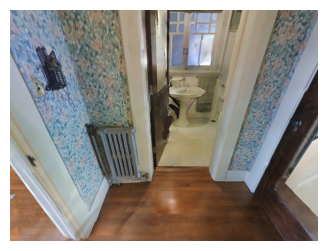

In [80]:
init_heading = train_data[0]['heading']
# renderer_dict = init_episode(scan_data, init_heading, 0, scan_data['mesh'])
init_heading = 0
init_elevation = np.deg2rad(-30)
renderer_dict = init_episode(scan_data, init_heading, init_elevation, scan_data['mesh'])

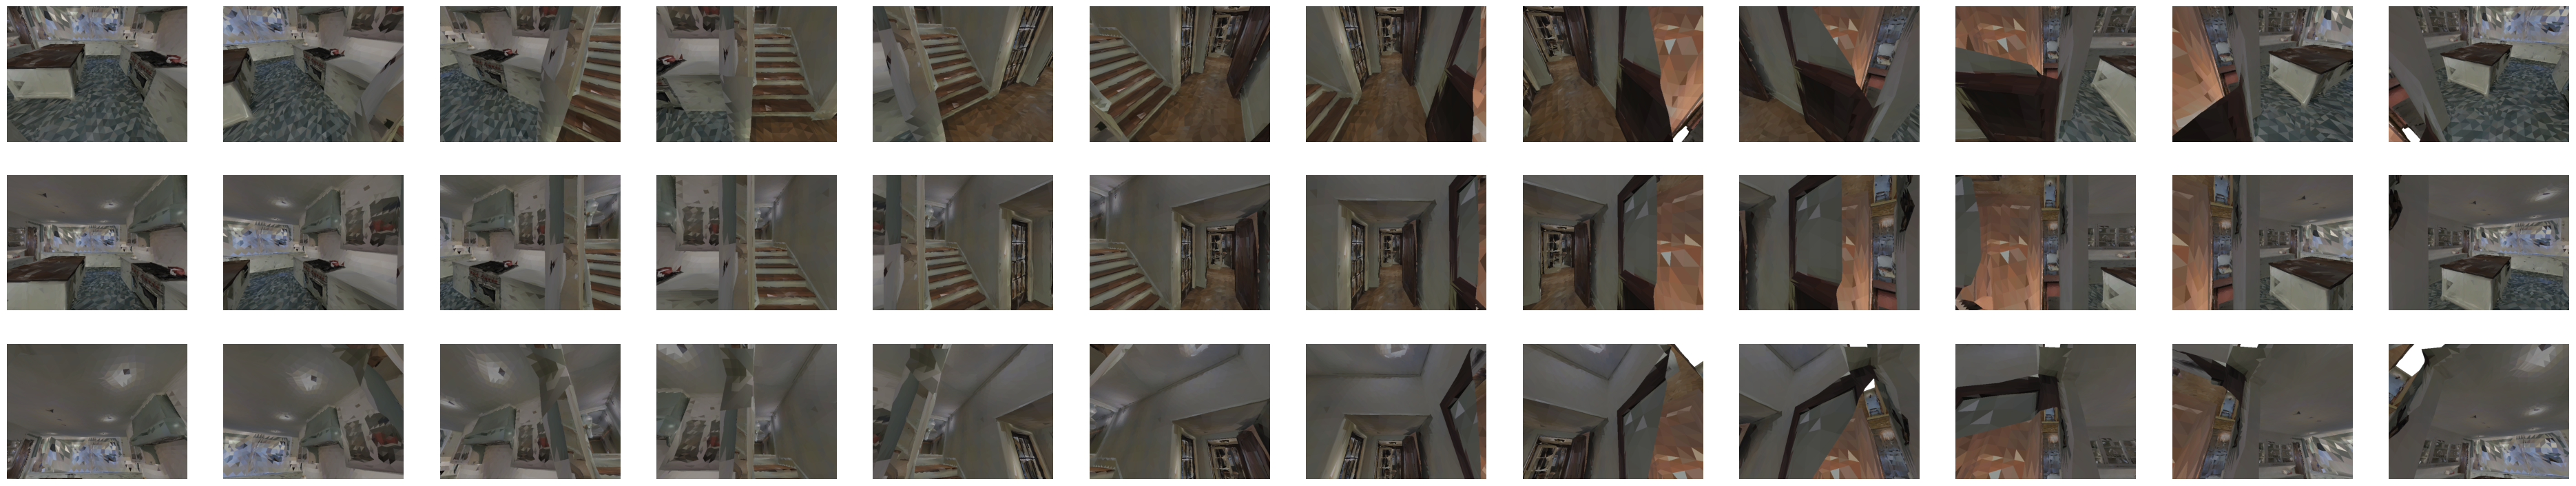

In [19]:

# R, T = look_at_view_transform(eye=[eye], up=[up], at=[at]) 
# cameras = FoVPerspectiveCameras(device=device, R=R, T=T, aspect_ratio=1, fov=75.0)

# raster_settings = RasterizationSettings(
#     image_size=((480, 640)), 
#     blur_radius=0.0, 
#     faces_per_pixel=1, 
# )

# renderer = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=cameras, 
#         raster_settings=raster_settings
#     ),
#     shader=SoftPhongShader(
#         device=device, 
#         cameras=cameras,
#         # lights=lights
#     )
# )
# get figure
rows = 3
cols = 12
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))

eye_init = renderer_dict['eye']
up_init = renderer_dict['up']
at_init = renderer_dict['at']

for e, elevation in enumerate(ELEVATIONS):
    for h, heading in enumerate(HEADINGS):
        # TODO need to make rotate_heading to work with elevation
        eye, at, up = rotate_heading_elevation(eye_init, at_init, up_init, heading, elevation)

        R, T = look_at_view_transform(eye=[eye], up=[up], at=[at]) 
        cameras = FoVPerspectiveCameras(device=device, R=R, T=T, aspect_ratio=1, fov=80.0)
        images = renderer_dict['renderer'](scan_data['mesh'], cameras=cameras)

        axes[e, h].imshow(images[0, ..., :3].cpu().numpy())
        axes[e, h].axis("off")
        # plt.figure(figsize=(4, 3))
        # plt.imshow(images[0, ..., :3].cpu().numpy())
        # plt.axis("off");
        # time.sleep(0.5)

    # eye, at, up = rotate_heading_elevation(eye, at, up, 0, elevation)
    
# images = renderer(mesh, cameras=cameras)
# plt.figure(figsize=(4, 3))
# plt.imshow(images[0, ..., :3].cpu().numpy())
# plt.axis("off");
# time.sleep(0.5)

In [ ]:
eye, up, at

(array([ 5.17571, 13.1223 ,  1.56227]),
 array([0, 0, 1]),
 array([ 5.66391143, 12.24956902,  1.56227   ]))

In [ ]:
import os

mesh_dir = '/mnt/sw/vln/data/matterport3d/mp3d_mesh/v1/scans/{}/matterport_mesh'
def get_obj_path(base_dir, scan_id):
    scan_path = base_dir.format(scan_id)
    obj_file_dir = scan_path + '/' + os.listdir(scan_path)[0]
    obj_file = [d for d in os.listdir(obj_file_dir) if d.endswith('.obj')][0]
    obj_path = os.path.join(scan_path, obj_file_dir, obj_file)   
    return obj_path

scan_id = '17DRP5sb8fy'
dir_to_test_obj = get_obj_path(mesh_dir, scan_id)


In [ ]:
axis = [0, 0, 1]
angle = 30

# matrix format
rotation = Rotation.from_rotvec(np.deg2rad(angle) * np.array(axis))
radians = np.deg2rad(30)
Rz_30 = np.array([[np.cos(radians), -np.sin(radians), 0],
                  [np.sin(radians),  np.cos(radians), 0],
                  [0,                0,               1]])
new_R = np.dot(R, Rz_30)

Eye (rotated): [13.7596, -7.11583, -1.37704]
At (rotated): [-1.71447815 -7.83314045  0.        ]
Up (rotated): [0 0 1]


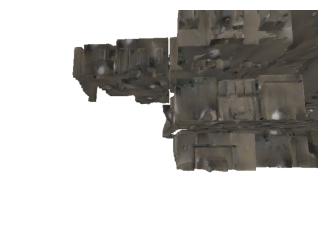

In [66]:


eye, at_rotated , up = rotate_heading(eye, at, up, np.deg2rad(30))
print("Eye (rotated):", eye)
print("At (rotated):", at_rotated)
print("Up (rotated):", up)  # Th
# axis = [0, 0,1] 
# angle = 30
# rotation = Rotation.from_rotvec(np.deg2rad(angle) * np.array(axis))

# new_R = np.dot(R, rotation.as_matrix())
R, T = look_at_view_transform(eye=[eye], up=[up], at=[at_rotated]) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, aspect_ratio=4/3, fov=75.0)
images = renderer(scan, cameras=cameras)
plt.figure(figsize=(4, 3))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [45]:
test_location

[-5.48891, 1.4484, 1.53509]

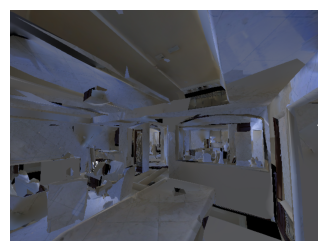

In [54]:
axis = [0, 0,1] 
angle = 30
rotation = Rotation.from_rotvec(np.deg2rad(angle) * np.array(axis))

new_R = np.dot(R, rotation.as_matrix())

R, T = look_at_view_transform(eye=[eye], up=[[0, 0, 1]], at=[at_rotated]) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, aspect_ratio=4/3, fov=75.0)
images = renderer(scan, cameras=cameras)
plt.figure(figsize=(4, 3))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [55]:
# Create a Meshes object
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.verts_idx.to(device)],
    # textures=textures
    textures=tex
)

# Render the plotly figure
fig = plot_scene({
    "subplot1": {
        "cow_mesh": mesh
    },
})
fig.update_layout(height=1000, width=1200)
fig.show()

NameError: name 'verts' is not defined

# use mp3d to guide the rendering step

In [9]:
import MatterSim

In [ ]:
sim = Matter

# Test block

In [94]:
transformed_vertices[:, 3][:, np.newaxis].shape

(8, 1)

In [ ]:

# Apply model, view, and projection matrices
transformed_vertices = homogeneous_vertices @ model_matrix.T @ view_matrix.T @ projection_matrix.T

# Divide by w to get NDC coordinates
ndc_vertices = transformed_vertices[:, :3] / transformed_vertices[:, 3][:, np.newaxis]

# Convert NDC coordinates to screen coordinates (assuming a 800x800 viewport)
screen_size = 800
screen_vertices = ((ndc_vertices + 1) / 2) * screen_size

# Visualize the resulting 2D screen coordinates
plt.figure(figsize=(8, 8))
for edge in edges:
    plt.plot(screen_vertices[edge, 0], screen_vertices[edge, 1], 'k-')
plt.gca().invert_yaxis()  # Invert the y-axis to match the usual screen orientation
plt.axis('equal')
plt.show()


# quick test and compare between generated image and original image. mainly check camera info

In [8]:
# load a pose 
import json
from render.config import cfg
from render.utils import load_viewpoints_dict, get_viewpoint_info
from render.render import load_meshes
from pytorch3d.renderer import (
    AmbientLights,
    FoVPerspectiveCameras,
    MeshRasterizer,
    MeshRenderer,
    RasterizationSettings,
    SoftPhongShader,
    look_at_view_transform,
)
from render.utils import get_device
from render.render import init_episode

In [9]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
cfg.merge_from_file('render_example/configs/mp3d_render_mac.yaml')

In [12]:
with open('./render_example/save/poses/val_unseen_pose.json') as f:
    scan_vp_poses = json.load(f)

_, _, scan_to_vps_to_data = load_viewpoints_dict(cfg.DATA.CONNECTIVITY_DIR)

test_render_set = scan_vp_poses['poses'][:5]
scan = test_render_set[0]['scan']
vp = test_render_set[0]['vp']
heading = test_render_set[0]['heading']
elevation = test_render_set[0]['elevation']
device = get_device()
mesh_data = load_meshes([scan], mesh_dir=cfg.DATA.MESH_DIR, device=device, texture_atlas_size=50)
viewpoint_info = get_viewpoint_info(scan, vp, scan_to_vps_to_data)


# cam_info = CameraData(viewpoint_info["pose"])

# set up meta data
# render settings


In [15]:
print(scan, vp, heading, elevation)

2azQ1b91cZZ c9f0045f40984820ac2bef8de7ce9dfc 0.0 -0.5235987755982988


In [16]:
from PIL import Image
import os

def read_image(scan, vp, heading, elevation):
    # find image and display for compare
    img_path = os.path.join(cfg.SAVE.IMAGE_DIR, scan, f'{scan}_{vp}_{heading}_{elevation}.png')
    img = Image.open(img_path)
    print("Image size:", img.size)
    img.show()
    return img
    
    

In [17]:
read_image(scan, vp, heading, elevation)

FileNotFoundError: [Errno 2] No such file or directory: 'render_example/save/images/2azQ1b91cZZ/2azQ1b91cZZ_c9f0045f40984820ac2bef8de7ce9dfc_0.0_-0.5235987755982988.png'

In [20]:
# get K matrix

import torch

# Parse the data
width, height, fx, fy, cx, cy, k1, k2, p1, p2, k3 = \
    [float(x) for x in "1280 1024 1071.65 1072.26 630.843 504.318 0.0533493 -0.209217 -3.85927e-05 -0.000318848 0.193577".split()]

# Construct the intrinsic matrix K
K = torch.tensor([
    [fx, 0, cx, 0],
    [0, fy, cy, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
K = K.unsqueeze(0)
# Print the K matrix
print(K)

tensor([[1.0717e+03, 0.0000e+00, 6.3084e+02, 0.0000e+00],
        [0.0000e+00, 1.0723e+03, 5.0432e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]])


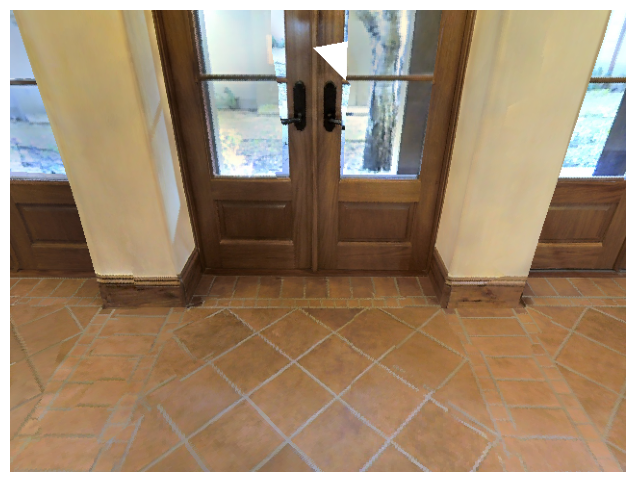

In [24]:

raster_settings = RasterizationSettings(
    image_size=((cfg.CAMERA.HEIGHT, cfg.CAMERA.WIDTH)),
    blur_radius=0.0,
    faces_per_pixel=1,
)


# set up renderer and intial view
# init_heading = 0
renderer_dict = init_episode(
    viewpoint_info,
    heading,
    elevation,
    raster_settings=raster_settings,
    cfg=cfg,
    device=device,
    mesh=mesh_data[scan],
)


In [25]:
mesh = renderer_dict['mesh']

## check the clip mesh

In [30]:
from pytorch3d.renderer.mesh.clip import ClipFrustum

In [31]:

# Define the view frustum parameters
left = -1
right = 1
top = 1
bottom = -1
znear = 0.1
zfar = 100

# Create a ClipFrustum object
clip_frustum = ClipFrustum(left=left, right=right, top=top, bottom=bottom, znear=znear, zfar=zfar)

In [39]:
from pytorch3d.renderer.mesh.clip import clip_faces, ClipFrustum

# Define the view frustum parameters
left = -1
right = 1
top = 1
bottom = -1
znear = 0.1
zfar = 100

# Create a ClipFrustum object
frustum = ClipFrustum(left=left, right=right, top=top, bottom=bottom, znear=znear, zfar=zfar)

# Load the mesh
# Clip the mesh based on the view frustum


In [42]:
mesh.num_faces_per_mesh()

tensor([161291])

In [46]:
mesh.mesh_to_faces_packed_first_idx()

tensor([0])

In [66]:
scan_id = '2azQ1b91cZZ'

In [69]:
mesh_data[scan_id]

(tensor([[ 3.0090e+01, -5.9625e-01,  1.0206e+00],
         [ 1.6006e+01, -1.3520e+01,  3.4820e+00],
         [ 2.9206e+00, -7.0777e+00,  5.8652e+00],
         ...,
         [ 1.4655e+01, -7.1210e-03,  3.6775e+00],
         [ 2.0138e+01, -1.1015e+01, -1.6469e-02],
         [ 2.0153e+01, -1.0830e+01, -1.3300e-02]]),
 tensor([[47928, 47241, 52289],
         [52252, 49378, 52248],
         [46140, 52384, 52238],
         ...,
         [ 5136,  5122,  5032],
         [ 5122,  5173,  5032],
         [ 5135,  5132,  5138]]),
 <pytorch3d.renderer.mesh.textures.TexturesAtlas at 0x28561a280>)

In [126]:
verts_packed, face_to_verts, texture  = mesh_data[scan_id] # (V, 3), (F, 3)
face2verts = torch.index_select(verts_packed, 0, face_to_verts.view(-1)) # (F*3, 3)
face_verts_unclipped = face2verts.view(face_to_verts.size()[0], 3, 3)
num_faces_per_mesh = mesh.num_faces_per_mesh()
mesh_to_face_first_idx = mesh.mesh_to_faces_packed_first_idx()

In [132]:

clipped_faces = clip_faces(face_verts_unclipped, mesh_to_face_first_idx, num_faces_per_mesh, frustum)


In [133]:
# select faces_to_verts from original mesh
clip_face_to_verts = torch.index_select(face_to_verts, 0, clipped_faces.faces_clipped_to_unclipped_idx)

In [149]:
texture.atlas_packed().shape

torch.Size([161291, 50, 50, 3])

In [150]:
clipped_texture = torch.index_select(texture.atlas_packed(), 0, clipped_faces.faces_clipped_to_unclipped_idx)

In [151]:
# new textureatlas



torch.Size([102359, 50, 50, 3])

In [136]:
clip_face_to_verts.shape

torch.Size([102359, 3])

In [135]:
face_to_verts.size()

torch.Size([161291, 3])

In [141]:
from pytorch3d.structures import Meshes

In [144]:
verts_packed.shape, clip_face_to_verts.shape

(torch.Size([87004, 3]), torch.Size([102359, 3]))

In [146]:

# Create a new mesh with the clipped faces
clipped_mesh = Meshes(
    verts=verts_packed.unsqueeze(0),
    faces=clip_face_to_verts.unsqueeze(0),
    # textures=texture,
)


In [147]:

# Render the clipped mesh
renderer = renderer_dict['renderer']
image = renderer(clipped_mesh)

ValueError: Meshes does not have textures

In [33]:
from pytorch3d.renderer.mesh.clip import ClipFrustum
import torch

# Define the camera frustum parameters
R = torch.eye(3)[None]  # Rotation matrix
T = torch.zeros(1, 3)  # Translation vector

# Clip the mesh based on the camera frustum
clipped_mesh = clip_frustum(mesh, R=R, T=T)


TypeError: 'ClipFrustum' object is not callable

In [ ]:

# Render the clipped mesh
renderer = MeshRenderer()
image = renderer(clipped_mesh)

## Check if we can backpropagate through the renderer to the mesh vertices

In [ ]:

# test rendering
# TODO update code to only update camera pose
images = renderer_dict["renderer"](
    mesh_data[scan], cameras=renderer_dict["camera"]
)
plt.figure(figsize=(4, 3))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.savefig(args.save_dir / "image.png", bbox_inches="tight")

# relevant pytorch3d testing

In [40]:
import torch
import numpy as np
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader
)
from pytorch3d.renderer.mesh.textures import TexturesVertex

# Create a mesh with per-vertex colors
verts = torch.tensor([
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0]
], dtype=torch.float32)
faces = torch.tensor([
    [0, 1, 2],
    [1, 3, 2]
], dtype=torch.int64)
colors = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [1.0, 1.0, 1.0]
], dtype=torch.float32)
mesh = Meshes(verts=[verts], faces=[faces], textures=TexturesVertex(verts_features=[colors])).to(device)

# Create a camera and view transform
R, T = look_at_view_transform(2.0, 0.0, 0.0)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Create a rasterization settings object
raster_settings = RasterizationSettings(
    image_size=256,
    blur_radius=0.0,
    faces_per_pixel=1,
    bin_size=None,
    max_faces_opengl=10_000_000,
    max_faces_per_bin=None,
    perspective_correct=True,
    clip_barycentric_coords=True,
    cull_backfaces=True,
    z_clip_value=None,
    cull_to_frustum=False
)

# Create a mesh renderer
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
shader = HardPhongShader(device=device, cameras=cameras).to(device)
renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

# Render the mesh
images = renderer(mesh)

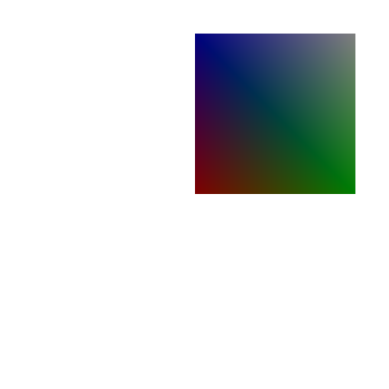

In [42]:
import matplotlib.pyplot as plt

plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.show()


In [ ]:
# generate the image and display it here


# mp3d render class 

In [ ]:
class Mp3dRenderer(nn.module):

    def render_scan_vp_at_heading_elevation(self, scan: str, vp: str, heading: float, elevation: float):
        pass